# Quality Match - Homework

### Chang Huan Lo

## Load data

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats

# open ref data file and transpose
ref_data = pd.read_json('references.json').T

# open annotator data file, transpose cols and rows, and extract nested data 
with open('anonymized_project.json') as f:
    d = json.load(f)
annotator_data = (pd.DataFrame(d['results']['root_node']['results'])
                  .T
                  .explode('results'))
annotator_data = pd.json_normalize(annotator_data['results'])

# detect missing values
annotator_data.isnull().values.any()

# convert string to datetime
annotator_data['created_at'] = pd.to_datetime(annotator_data['created_at'])

In [2]:
# function to plot timeline of all responses for an annotator
def plot_response_timeline(annotator_id, ax):    
    df = annotator_data.query('`user.vendor_user_id` == @annotator_id')
    x = df['created_at']
    y = df['task_output.answer']
    s = pd.Series(y.values, index = x)
    
    # plot blue for 'yes' and 'no'
    s1 = s[s != ""]
    times = list(zip(s1.index.view(np.int64), np.ones(len(s1))))
    plt.broken_barh(times, (-1,1), color = 'C0')

    # plot red for 'can't solve' or 'corrupt data' 
    s2 = s[s == ""]
    times = list(zip(s2.index.view(np.int64), np.ones(len(s2))))
    plt.broken_barh(times, (-1,1), color = 'r')

    # format axes
    ax.margins(0)
    ax.set_yticks([])
    ax.set_xticks([])

    
# function to plot boxplot for performance metrics
def identify_outliers(metric):
    # compute boxplot fences
    q1 = perf[metric].quantile(0.25)
    q3 = perf[metric].quantile(0.75)
    iqr = q3 - q1
    lower_fence = q1 - 1.5 * iqr
    upper_fence = q3 + 1.5 * iqr

    # plot accuracy
    plot = perf[metric].plot(kind='box')

    # annotate outliers in boxplot
    for index, met in perf[metric].iteritems():
        if met > upper_fence or met < lower_fence:
            plot.annotate(
                index,
                (1.02, met),
                fontsize = 8)

    # identify outliers
    print(perf[perf[metric] < lower_fence].index.values)

## Gather insights about the annotators

### How many annotators did contribute to the dataset?

In [3]:
annotator_data['user.id'].nunique()

22

### What are the average, min and max annotation times (durations)? 

In [4]:
annotator_data['task_output.duration_ms'].describe()

count    90870.000000
mean      1284.333873
std       1351.960465
min     -99999.000000
25%        887.000000
50%       1058.000000
75%       1328.000000
max      42398.000000
Name: task_output.duration_ms, dtype: float64

### Did all annotators produce the same amount of results, or are there differences?

No. Annotator_02 produced the most results (*n*=7596), while annotator_19 produced the fewest (*n*=170).

<AxesSubplot:>

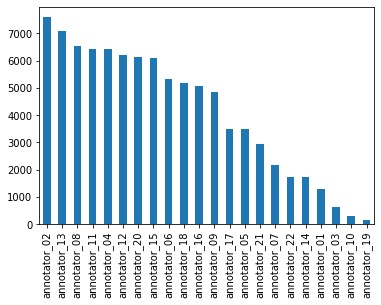

In [5]:
annotator_counts = annotator_data['user.vendor_user_id'].value_counts()
annotator_counts.plot(kind='bar')

In [6]:
annotator_counts

annotator_02    7596
annotator_13    7078
annotator_08    6537
annotator_11    6436
annotator_04    6421
annotator_12    6210
annotator_20    6126
annotator_15    6088
annotator_06    5337
annotator_18    5170
annotator_16    5061
annotator_09    4860
annotator_17    3485
annotator_05    3475
annotator_21    2950
annotator_07    2175
annotator_22    1745
annotator_14    1725
annotator_01    1280
annotator_03     630
annotator_10     315
annotator_19     170
Name: user.vendor_user_id, dtype: int64

### Are there questions for which annotators highly disagree?

There are 197 questions where agreement is lower than 70%.

<AxesSubplot:>

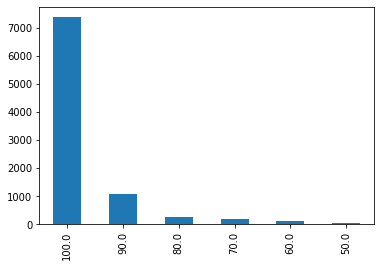

In [7]:
# for each question, count number of yes, no
agree = annotator_data.groupby(['task_input.image_url', 'task_output.answer']).size().unstack(fill_value=0)
agree['percentage'] = agree[['', 'no', 'yes']].max(axis=1) / agree[['', 'no', 'yes']].sum(axis=1) * 100
agree['percentage'].value_counts().plot(kind='bar')

In [8]:
agree['percentage'].value_counts()

100.0    7369
90.0     1083
80.0      250
70.0      188
60.0      129
50.0       68
Name: percentage, dtype: int64

## Besides picking yes or no the annotators had the chance to tell if the data were corrupted ('corrupt_data') or if they for any reason were not able to solve the task ('cant_solve').

### How often does each occur in the project?

In [9]:
annotator_data['task_output.corrupt_data'].value_counts() # 4 corrupt

False    90866
True         4
Name: task_output.corrupt_data, dtype: int64

In [10]:
annotator_data['task_output.cant_solve'].value_counts() # 17 can't solve

False    90853
True        17
Name: task_output.cant_solve, dtype: int64

###  Do you see a trend within the annotators that made use of these options?

To answer this question, we explore:
* Number of responses produced
* Timeline of responses
* Reaction time

#### Number of responses produced

Of the 10 annotators who made use of these options, 7 are among the top 10 contributors in terms of the number of responses produced:

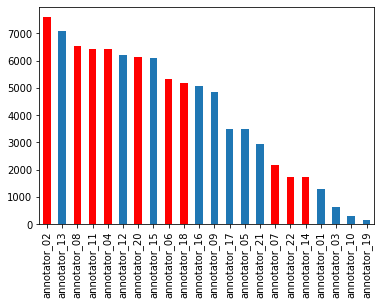

In [11]:
# get annotators who marked any row with 'cant solve' or 'corrupt data'
no_answer_users = annotator_data.query('`task_output.cant_solve` | `task_output.corrupt_data`')['user.vendor_user_id'].unique()

plot_counts = annotator_counts.plot(kind='bar')

# highlight these annotators in plot
for ticks in plot_counts.xaxis.get_major_ticks():
    if ticks.label1.get_text() in no_answer_users:
        plot_counts.patches[annotator_counts.index.get_loc(ticks.label1.get_text())].set_facecolor('r')


#### Timeline of responses

Red line: time point at which a question was marked as 'corrupt data' or 'cant solve'. <br>
Blue line: time point at which a question was marked as 'yes' or 'no'. 

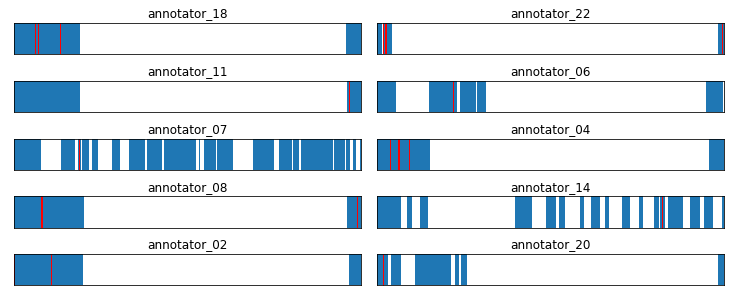

In [12]:
# plot timeline of responses for annotators who marked any row with 'cant solve' or 'corrupt data'
fig = plt.figure(constrained_layout=True, figsize = (10,4))
nrows = np.ceil(no_answer_users.size/2).astype('int')
subfigs = fig.subfigures(nrows, 2)

for i, subfig in enumerate(subfigs.flat):
    ax = subfig.subplots()
    ax.set_title(no_answer_users[i])
    plot_response_timeline(no_answer_users[i], ax)

plt.show()

#### Reaction time

A Welch's *t*-test reveals no significant difference in mean RT between annotators who used the 'corrupt data' and 'cant solve' options ('True' in the plot below) and those who did not ('False' in the plot below); *p*=.721.

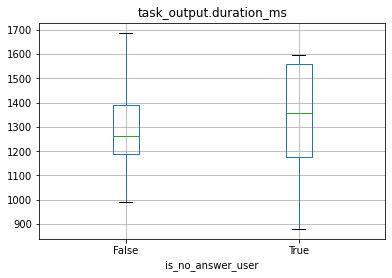

In [16]:
# exclude negative RTs
groupby_user = annotator_data.query('`task_output.duration_ms` >= 0').groupby('user.vendor_user_id')

# summarise 'cant solve', 'corrupt data', 'duration'
counts = groupby_user.size().to_frame(name = 'counts')
summary = (counts
           .join(groupby_user.agg({i: 'mean' for i in ['task_output.cant_solve', 
                                               'task_output.corrupt_data',
                                               'task_output.duration_ms']}))
)
summary['is_no_answer_user'] = summary.index.isin(no_answer_users)
summary.boxplot(column = 'task_output.duration_ms', by = 'is_no_answer_user')
plt.suptitle('')
plt.show()

In [17]:
# Welch's t-test on annotators' mean RTs
group_no_answer = summary.query('`user.vendor_user_id` in @no_answer_users')
group_answer = summary.query('`user.vendor_user_id` not in @no_answer_users')
stats.ttest_ind(group_no_answer['task_output.duration_ms'], group_answer['task_output.duration_ms'], equal_var=False)

Ttest_indResult(statistic=0.3632476266832818, pvalue=0.7208231967549894)

## Is the reference set balanced?

Yes, with similar number of True (*n* = 4586) and False (*n* = 4501) responses.

<AxesSubplot:ylabel='is_bicycle'>

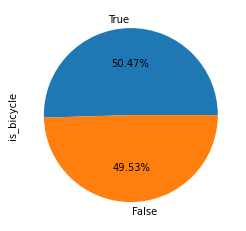

In [18]:
ref_data.value_counts()
ref_data['is_bicycle'].value_counts().plot(kind='pie', y='is_bicycle', autopct='%1.2f%%')

## Using the reference set, can you identify good and bad annotators? 

We compute two metrics:
* Accuracy
* F-score

In [19]:
# extract image name
annotator_data['image'] = annotator_data['task_input.image_url'].str.extract(r'(img_\d+)')

# merge annotator data with ref data
annotator_data = annotator_data.merge(ref_data, left_on='image', right_index=True)

# populate columns for confusion matrix: true positive, false positive, true negative, false negative
annotator_data['TP'] = np.where((annotator_data['task_output.answer'] == 'yes') & (annotator_data['is_bicycle']), True, False)
annotator_data['FP'] = np.where((annotator_data['task_output.answer'] == 'yes') & (~annotator_data['is_bicycle']), True, False)
annotator_data['TN'] = np.where((annotator_data['task_output.answer'] == 'no') & (~annotator_data['is_bicycle']), True, False)
annotator_data['FN'] = np.where((annotator_data['task_output.answer'] == 'no') & (annotator_data['is_bicycle']), True, False)

# compute metrics
perf = (annotator_data.query('`task_output.answer` != ""')
        .groupby('user.vendor_user_id')
        .agg({i:'sum' for i in ['TP','FP','TN','FN']}))
perf = perf.assign(accuracy = lambda x: (x.TP + x.TN) / (x.TP + x.FP + x.TN + x.FN),
                   recall = lambda x: x.TP / (x.TP + x.FN),
                   precision = lambda x: x.TP / (x.TP + x.FP),
                   fscore = lambda x: 2 / ((1 / x.recall) + (1 / x.precision)))

### Accuracy

The bad annotators (i.e., outliers in boxplot) are:

['annotator_08' 'annotator_10']


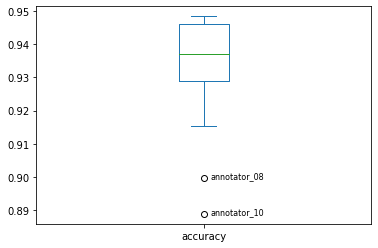

In [20]:
identify_outliers('accuracy')

### F-score

The bad annotators (i.e., outliers in boxplot) are:

['annotator_08' 'annotator_10']


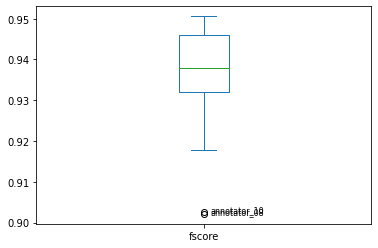

In [21]:
identify_outliers('fscore')